# Introduction
The "Recommendation System for Spotify" project is focused on leveraging machine learning techniques to provide personalized music recommendations. The system will use a CSV file containing metadata for 150,000 songs to generate suggestions based on the user's musical preferences. At the start, users will input their musical tastes, and the system will propose songs tailored to those preferences. After listening to the recommended songs on Spotify, users can rate them on a scale from 0 to 5. These ratings will then be incorporated into the system to refine future recommendations, ensuring that the suggestions become more accurate as the user interacts with the system. This project aims to enhance the user experience by offering a dynamic, learning-based approach to music discovery.

In [2]:

import pandas as pd
import requests
import base64
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import tensorflow as tf

## Note
Please, do not run the cell below as it will overwrite the CSV file.

In [2]:
data = pd.read_csv('dataset.csv')
data

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,...,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
113996,113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,...,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
113997,113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,...,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
113998,113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,...,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


## Comment
* **track_id**: The Spotify ID for the track
artists: The artists' names who performed the track. If there is more than one artist, they are separated by a ;
* **album_name**: The album name in which the track appears
* **track_name**: Name of the track
* **popularity**: The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.
* **duration_ms**: The track length in milliseconds
* **explicit**: Whether or not the track has explicit lyrics (true = yes it does; false = no it does not OR unknown)
* **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable
* **energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale
key: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1
* **loudness**: The overall loudness of a track in decibels (dB)
* **mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0
* **speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks
* **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic
* **instrumentalness**: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content
* **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live
* **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
* **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration
* **time_signature**: An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of 3/4, to 7/4.
* **track_genre**: The genre in which the track belongs


### NOTE
Please, do not run the cells about spotify api because it .will caused the error( missing the client id)

In [ ]:
CLIENT_ID = 'The client ID obtained from the Spotify Developer Portal'
CLIENT_SECRET = 'The client secret obtained from the Spotify Developer Portal'

def get_access_token(client_id, client_secret):
    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + base64.b64encode(f"{client_id}:{client_secret}".encode()).decode()
    }
    data = {"grant_type": "client_credentials"}

    response = requests.post(url, headers=headers, data=data)
    response_data = response.json()
    return response_data.get("access_token")

token = get_access_token(CLIENT_ID, CLIENT_SECRET)
print("Access Token:", token)

In [12]:
def get_tracks_urls(batch_ids):
    headers = {
        "Authorization": f"Bearer {token}"
    }
    SPOTIFY_API_BASE = "https://api.spotify.com/v1/tracks"
    ids_param = ",".join(batch_ids)
    url = f"{SPOTIFY_API_BASE}?ids={ids_param}"
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        data = response.json()
        results = {}
        for track in data.get("tracks", []):
            if track:

                track_url = track.get("external_urls", {}).get("spotify", None)
                if track_url:
                    results[track["id"]] = track_url
        return results
    elif response.status_code == 429:
        retry_after = int(response.headers.get("Retry-After", 5))
        print(f"Rate limit exceeded. Waiting for {retry_after} seconds...")
        time.sleep(retry_after)
        return get_tracks_urls(batch_ids)
    else:
        print(f"Error {response.status_code}: {response.text}")
        return []

In [14]:
batch_size = 50
results = []
track_ids = data['track_id'].tolist()
url_mapping = {}  # Mapa track_id -> url

for i in range(0, len(track_ids), batch_size):
    batch = track_ids[i:i + batch_size]
    print(f"Processing batch {i // batch_size + 1} with {len(batch)} tracks...")
    batch_results = get_tracks_urls(batch)
    for track_id, url in batch_results.items():
        data.loc[data['track_id'] == track_id, 'url'] = url
    print(f"Processed {len(batch_results)} records so far. Waiting for 30 seconds...")
    time.sleep(0.4)


print("URLs added to the DataFrame!")

Processing batch 1 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 2 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 3 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 4 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 5 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 6 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 7 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 8 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 9 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 10 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 11 with 50 tracks...
Processed 50 records so far. Waiting for 

In [15]:
df_helper=data.copy()

In [16]:
# Do not run this cell it will overrite the existing CSV file
#df_helper.to_csv("csv_with_URL_1.csv", index=False)

## Comment

This script interacts with the Spotify API to fetch external URLs for a list of track IDs. It begins by authenticating with the Spotify API using the CLIENT_ID and CLIENT_SECRET, obtaining an access token required for subsequent API requests. The track IDs are processed in batches of 50, which is the maximum number allowed per API call, ensuring efficient use of resources. For each batch, the script retrieves the corresponding external Spotify URLs and maps them back to the track IDs, updating a DataFrame with these URLs. To handle potential rate limits imposed by the Spotify API, the script monitors the response headers and pauses execution when necessary, waiting for the time specified in the Retry-After header. This ensures the process remains compliant with Spotify's API policies while gradually populating the DataFrame with track URLs in a reliable and efficient manner.

I want to leave it here because I want to show to I had to also work with the API and please appreciate that I have done because I caused me a lot of effort because the API has the limit and I was able to send the request for only 50 tracks. With 115000 tracks and time limit on the requests, it took me 3 hours...(there was a lot of errors from the Spotify side) :)

## Note
Please run this cell below, and you can run all cells from that moment

In [3]:
df=pd.read_csv("csv_with_URL_1.csv")

In [4]:
print(f'number of duplicate rows: {df.duplicated().sum()}\nnumber of null values:\n{df.isna().sum()}')

number of duplicate rows: 0
number of null values:
Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
url                 0
dtype: int64


In [5]:
null_artists = df.loc[pd.isna(df['artists'])]
null_artists

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,url
65900,65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,0,0,False,0.501,0.583,...,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop,https://open.spotify.com/track/1kR4gIb7nGxHPI3...


In [6]:
df=df.dropna(subset=['artists'])

In [9]:
df.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'url'],
      dtype='object')

In [10]:
set_track_genre=set()
for genres in df['track_genre']:
    set_track_genre.add(genres)
map_track_genre={}
for i,genre in enumerate(set_track_genre, start=1):
    map_track_genre[genre]=i
df['track_genre_number']=df['track_genre'].map(map_track_genre)

In [11]:
df['explicit']=df['explicit'].astype('int')

In [12]:
df.drop_duplicates(subset=['track_name', 'artists'],inplace=True)
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.reset_index(drop=True,inplace=True)

In [14]:
numeric_data=df.select_dtypes(include=['int64','float64'])
#numeric_data.drop(['Unnamed: 0'],axis=1,inplace=True)
numeric_data


,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre_number
0,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,93
1,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,93
2,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,93
3,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,93
4,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81338,21,384999,0,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,57
81339,22,385000,0,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,57
81340,22,271466,0,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,57
81341,41,283893,0,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,57


## Comment
This script cleans and preprocesses a DataFrame by removing rows with missing values in the artists column and duplicates based on track_name and artists. It maps unique track_genre values to numeric identifiers in a new column, converts the explicit column to integers, and drops unnecessary columns like Unnamed: 0 ( Now, It is commented out because sometimes the Jupyter gives the addicional column called Unnamed and sometimes not). Finally, it extracts numeric columns for further analysis, ensuring the dataset is ready for modeling or computation.

# Exploratory Data Analysis

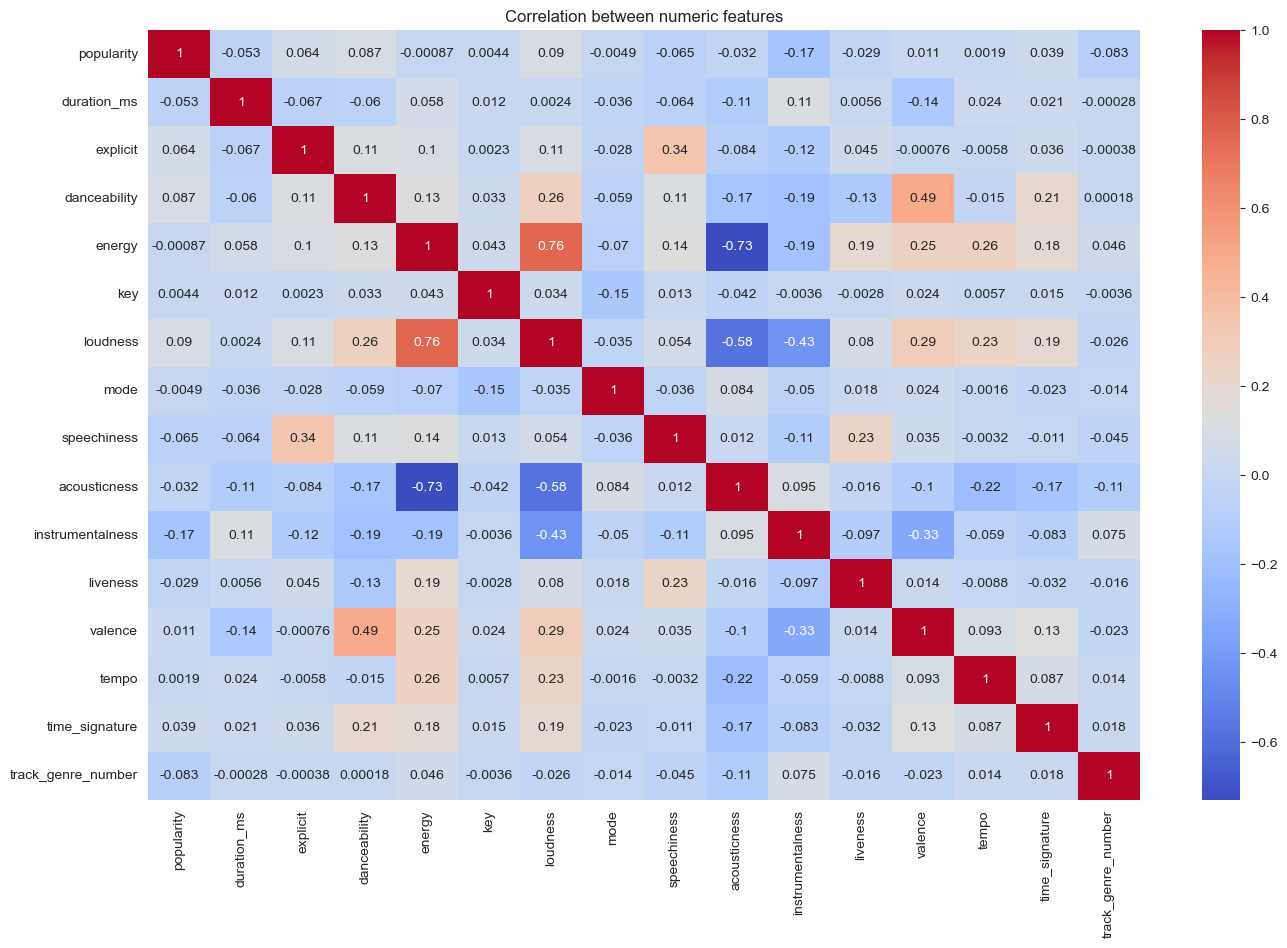

In [87]:
plt.figure(figsize=(16, 10))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between numeric features')
plt.show()

## Comment
Insights from the Correlation Matrix:
1. Energy and Loudness:
The strongest positive correlation is observed between energy and loudness, which is intuitive. Louder music tends to feel more energetic, creating a direct connection between these two features.
2. Valence with danceability, Energy, and Loudness:
Valence, which measures the happiness or positivity conveyed by the music, shows notable positive correlations with danceability, energy, and loudness. This indicates that happier songs are often more danceable, energetic, and loud, contributing to their overall upbeat nature. Such tracks tend to resonate well on dance floors or in lively settings.
3. Time Signature and danceability:
The correlation between time signature and danceability is intriguing. A consistent time signature can make a track easier to follow rhythmically, enhancing its suitability for dancing. Tracks with irregular time signatures may be less danceable due to their complex rhythms.
4. Acousticness and Energy:
A strong negative correlation (-0.73) exists between acousticness and energy. This suggests that acoustic tracks are generally less energetic, often emphasizing softer, more mellow tones instead of high-intensity beats.
5. Acousticness and Loudness:
The correlation between acousticness and loudness highlights that acoustic songs tend to be quieter. This aligns with the typical nature of acoustic music, which prioritizes subtlety and clarity over loudness.
6. Track Genre and Other Features:
Interestingly, track genre does not exhibit any significant correlation with other features. This suggests that genre alone may not directly dictate specific musical characteristics such as energy, danceability, or valence. Instead, genres might be more nuanced, capturing a broader range of musical diversity.

Text(0, 0.5, 'Energy')

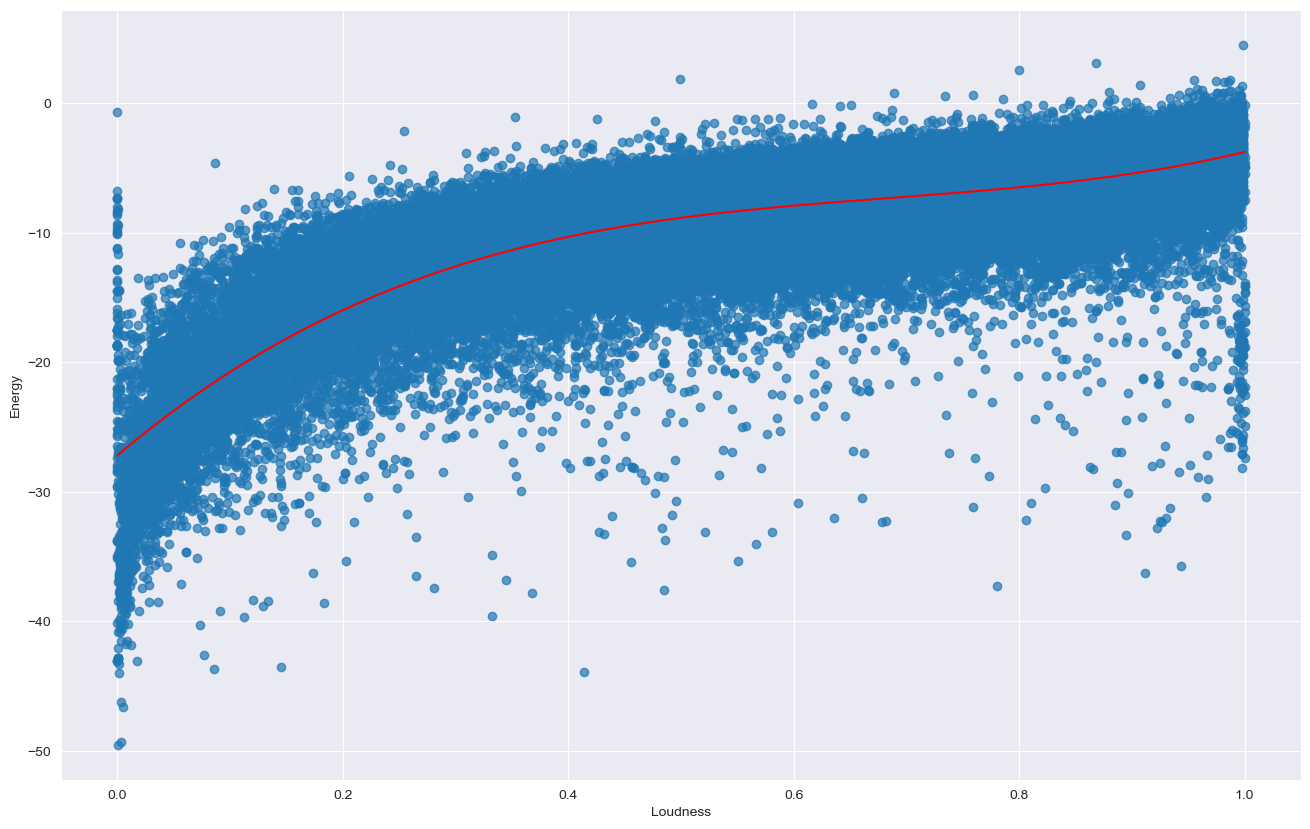

In [88]:
x=numeric_data['energy']
y=numeric_data['loudness']

degree=3
cooeficients=np.polyfit(x,y,degree)
polynomial=np.poly1d(cooeficients)

x_sorted=np.sort(x)
y_fit=polynomial(x_sorted)
plt.figure(figsize=(16, 10))
plt.scatter(x, y, alpha=0.7, label="Data points")
plt.plot(x_sorted, y_fit, color='red', label=f"Polynomial Regression (degree {degree})")
plt.xlabel('Loudness')
plt.ylabel('Energy')

### Note:
The loudness values are negative because they show how loud a song is compared to the maximum possible loudness (0 dB). Negative values mean the song is quieter than the maximum level, which is normal for most music. It helps keep the sound balanced and avoids distortion.

## Comment
A polynomial regression line of the third degree (shown in red) has been fitted to the data. The overall trend indicates that as the x-variable increases, the loudness tends to become less negative, reflecting higher loudness levels. However, there is a noticeable spread in the data points, suggesting significant variability in loudness for intermediate values of the x-variable. The fitted polynomial regression captures the general trend, but it may not fully explain the variability of the data.

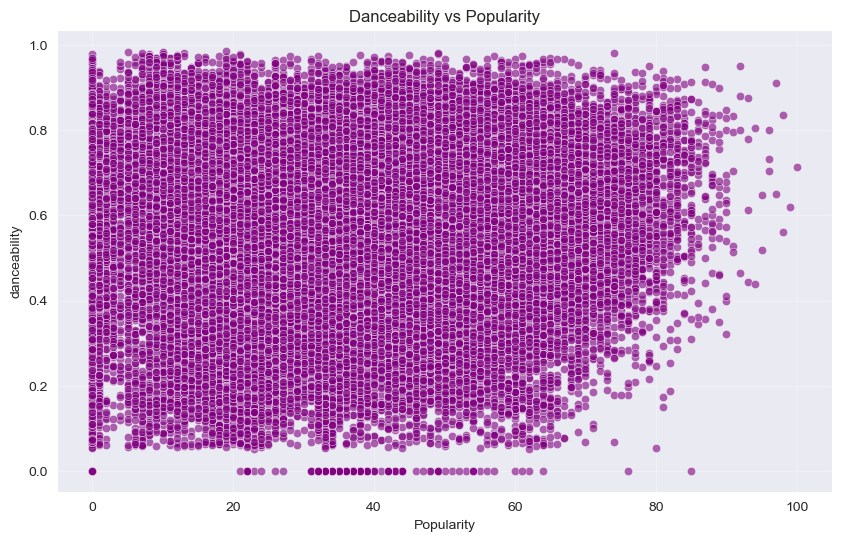

In [89]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='popularity', y='danceability', data=numeric_data, alpha=0.6, color='purple')
plt.title('Danceability vs Popularity')
plt.xlabel('Popularity')
plt.ylabel('danceability')
plt.grid(alpha=0.3)
plt.show()


## Comment

The relationship between danceability and popularity is intriguing, as it does not show a strong correlation. However, an interesting pattern emerges: after a popularity score of 60, there is a noticeable decrease in the number of low-danceability songs. Additionally, the most popular songs tend to have a danceability score above 50.

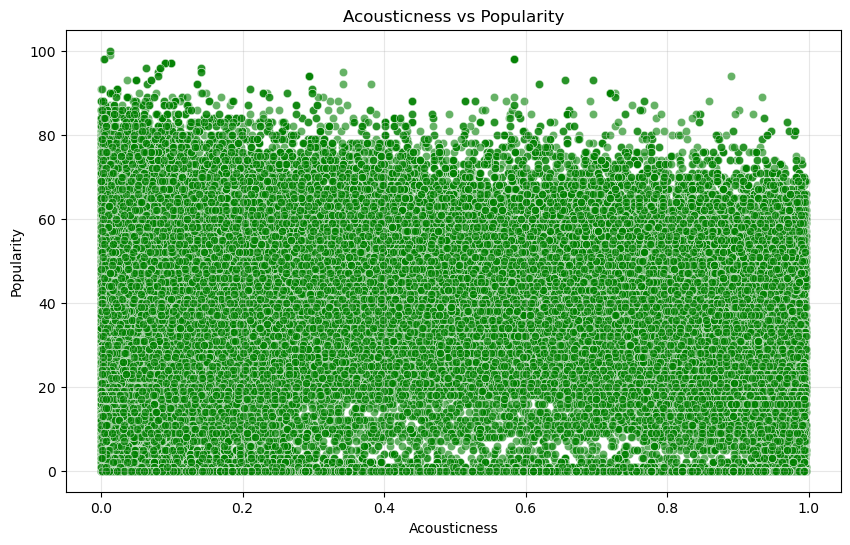

In [103]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='acousticness', y='popularity', data=data, alpha=0.6, color='green')
plt.title('Acousticness vs Popularity')
plt.xlabel('Acousticness')
plt.ylabel('Popularity')
plt.grid(alpha=0.3)
plt.show()


## Comment

There is an observable decreasing trend in acousticness with increasing popularity, indicating that the most popular songs (popularity score 80-100) are generally not acoustic. This suggests that listeners tend to prefer songs with less acoustic elements as their popularity grows, possibly favoring more energetic produced tracks.

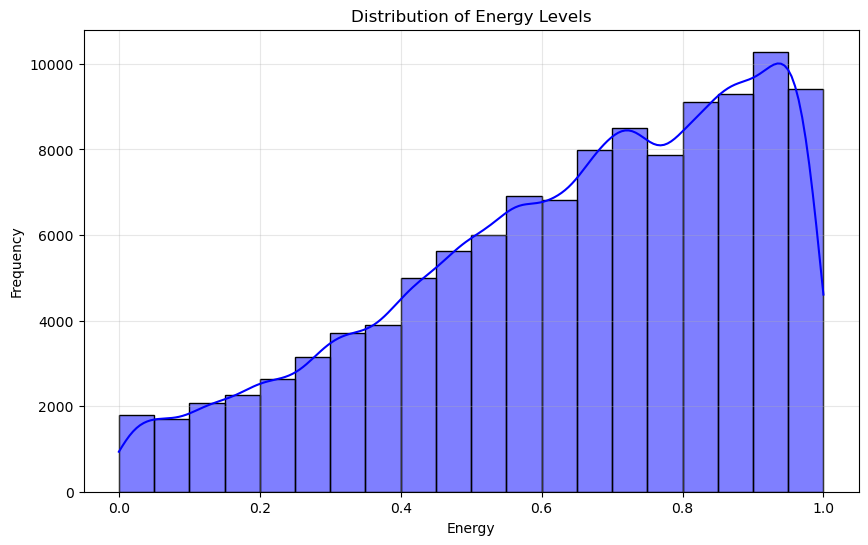

In [106]:
plt.figure(figsize=(10, 6))
sns.histplot(data['energy'], bins=20, kde=True, color='blue')
plt.title('Distribution of Energy Levels')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()


## Comment
As we can see, most songs tend to be more energetic, indicating that people are likely to prefer energetic tracks. This plot is particularly interesting because the distribution appears to follow a linear pattern with some noise. The linearity might be explained by the way energy is produced and measured in songs, as it often correlates with certain technical aspects like tempo, loudness, and instrumental arrangements. Producers and artists might also aim for a balanced range of energy levels to cater to diverse audience preferences while maintaining a structured progression in their music. This alignment could also reflect how listeners subconsciously gravitate toward songs with consistent energy trends across various genres.

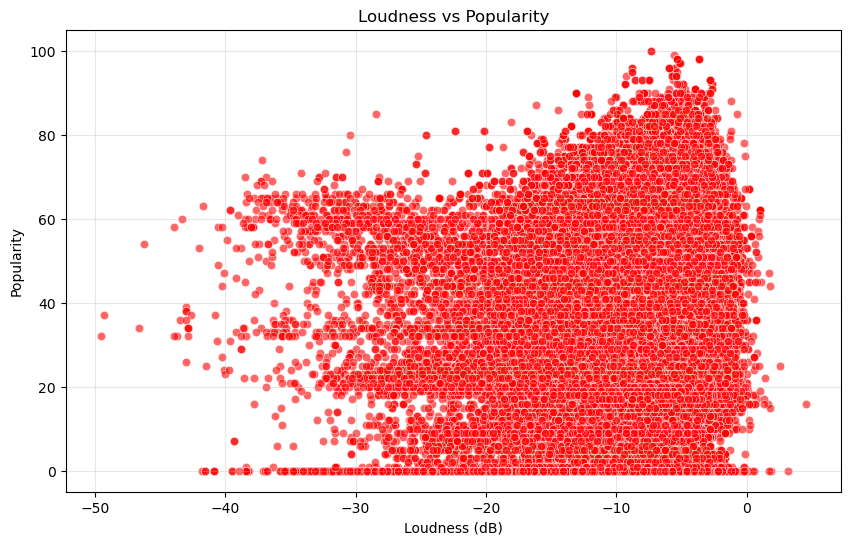

In [107]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='loudness', y='popularity', data=data, alpha=0.6, color='red')
plt.title('Loudness vs Popularity')
plt.xlabel('Loudness (dB)')
plt.ylabel('Popularity')
plt.grid(alpha=0.3)
plt.show()


## Comment

The distribution of points is quite intriguing and suggests the presence of interesting patterns. First, there is a notable concentration of songs with loudness between -40 and -30 dB that have a popularity score above 60. This implies that if you're creating a song that is quieter and slower, aiming for this loudness range might resonate well with listeners. On the other hand, the most popular songs tend to be much louder, typically falling within the range of -10 to 0 dB. Interestingly, there are no songs with loudness between -50 and -15 dB that achieve a popularity score above 90. This gap could indicate that songs in this intermediate range might lack the qualities—such as energy or clarity—that tend to appeal to a broader audience, highlighting the importance of fine-tuning loudness to match listener preferences.

# Data modeling

In [90]:
numeric_data.to_csv("csv_with_numeric_data.csv", index=False)

In [15]:
numeric_data_scaled=numeric_data.copy()
scaler = MinMaxScaler()
numeric_data_scaled=scaler.fit_transform(numeric_data_scaled)

song_lists=df['track_name']
song_URLs=df['url']
song_lists = song_lists.reset_index(drop=True)
song_URLs = song_URLs.reset_index(drop=True)

normalized_features = [ 'popularity','duration_ms', 'explicit', 'danceability', 'energy',
                        'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                        'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
                        'track_genre_number']
#numeric_data

## Comment
Here, I normalized data using Min Max scaler. I believe that this is the best normalization method to all of this features because most of them have the range between 0 to 1.

In [16]:

def recommend_cosine(data_normalized, user_profile, top_n=5):
    print(data_normalized.shape)
    print("Calculating cosine similarity...")
    similarity = cosine_similarity(user_profile, data_normalized)
    indices = np.argsort(similarity[0])[::-1][:top_n]
    print("Recommended songs:")
    return indices

## Comment
Here, we have cosine_similarity method that createes a vector for the user and all the songs in the dataset and counts to cosine between them. The bigger the result is, the better the song fits to the person.

In [17]:
def recommend_knn(data_normalized, user_profile, top_n=5):
    print("Calculating k-nearest neighbors...")
    knn=NearestNeighbors(n_neighbors=top_n,metric='minkowski')
    knn.fit(data_normalized)
    distances,indices=knn.kneighbors(user_profile)
    return indices[0]

## Comment

This function implements a recommendation system using the k-nearest neighbors (KNN) algorithm to identify items similar to a user's preferences. It takes a normalized dataset (data_normalized), a user_profile representing the user's preferences, and an optional parameter top_n specifying the number of nearest neighbors to return. The function initializes a KNN model with the Minkowski distance metric and fits it to the normalized data, capturing the relationships between data points. It then computes the nearest neighbors for the user_profile, returning the indices of the top n most similar items.

In [18]:
def recommend_pca(data_normalized,user_profile,top_n=5):
    pca=PCA(n_components=2)
    reduced_data=pca.fit_transform(data_normalized)
    reduced_user=pca.transform(user_profile)
    distances=np.linalg.norm(reduced_data-reduced_user,axis=1)
    indices = np.argsort(distances)[:top_n]
    return indices



## Comment
This function uses Principal Component Analysis (PCA) to recommend items by reducing the dimensionality of the dataset to its most important components. PCA transforms the data into a lower-dimensional space, capturing the directions of maximum variance while discarding noise or less relevant features. The function reduces both the normalized dataset and the user's profile to two principal components (n_components=2). It then computes Euclidean distances between the reduced user profile and each data point to identify the top_n closest items. By focusing on the most significant patterns, PCA enhances the recommendation process, especially in high-dimensional datasets.

In [19]:
X = numeric_data_scaled

input_dim = X.shape[1]
encoding_dim = 3

input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = tf.keras.layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=decoded)
encoder = tf.keras.models.Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X, X, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

encoded_features = encoder.predict(X)

Epoch 1/50
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 1s 308us/step - loss: 0.0711 - val_loss: 0.0349
Epoch 2/50
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 1s 282us/step - loss: 0.0318 - val_loss: 0.0309
Epoch 3/50
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 1s 268us/step - loss: 0.0281 - val_loss: 0.0290
Epoch 4/50
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step - loss: 0.0266 - val_loss: 0.0281
Epoch 5/50
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - loss: 0.0256 - val_loss: 0.0273
Epoch 6/50
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step - loss: 0.0249 - val_loss: 0.0269
Epoch 7/50
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step - loss: 0.0245 - val_loss: 0.0265
Epoch 8/50
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 1s 275us/step - loss: 0.0243 - val_loss: 0.0265
Epoch 9/50
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step - loss: 0.0239 - val_loss: 0.0264
Epoch 10/50
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 1s 275us/step - loss: 0.0238 - val_loss: 0.0262
Epoch 11/50
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 1s 268us/step - loss: 0.0236 - val_loss: 0.0261
Epoch 12

In [20]:
def recommend_autoencoder(data_normalized,user_profile):
    user_encoded = encoder.predict(user_profile.reshape(1, -1))
    distances = np.linalg.norm(encoded_features - user_encoded, axis=1)
    recommended_indices = np.argsort(distances)[:5]
    return recommended_indices

# Comment
This code uses an autoencoder, a neural network for dimensionality reduction and feature extraction, to recommend items. The autoencoder compresses the input data (numeric_data_scaled) into a smaller latent space (encoding_dim=3) via the encoder and reconstructs it using the decoder. The model is trained to minimize reconstruction error using mean squared error (MSE). After training, the encoder extracts compact representations of the dataset. For recommendations, the user profile is transformed into the same latent space, and distances to all encoded data points are calculated. The top 5 closest items are identified as recommendations, making this method effective for capturing complex patterns in high-dimensional data.

In [71]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
preference_questions = {
    'danceability': "Do you like danceable  songs? (0-5):",
    'energy': "DOyou like energetic songs? (0-5):",
    'loudness': "Do you like loud songs? (0-5):",
    'valence': "Do you prefer happy or sad songs? (valence) (0-5):",
    'acousticness': "Do you like acoustic songs? (0-5):",
    'popularity': "How much do you like popular songs? (0 - Doesn't matter, 5 - Very important):",
    'explicit': "Does explicit language in song lyrics matter to you? (0 - Doesn't bother me, 5 - Prefer no explicit language):",
    'instrumentalness': "Do you like instrumental songs without vocals? (0 - Don't like, 5 - Love them):",
    'tempo': "What tempo do you prefer in songs? (e.g., slow, moderate, fast):"
}


preference_widgets = {
    feature: widgets.VBox([
        widgets.Label(value=preference_questions[feature], layout=widgets.Layout(margin='0 0 5px 0')),
        widgets.FloatSlider(
            value=2.5,
            min=0,
            max=5,
            step=0.1,
            description=feature,
            layout=widgets.Layout(width='80%')
        )
    ])
    for feature in preference_questions.keys()
}

submit_preferences_button = widgets.Button(description="Submit Preferences", button_style='success')


model_dropdown = widgets.Dropdown(
    options=[
        ('Cosine Similarity', 'cosine'),
        ('K-Nearest Neighbors', 'KNN'),
        ('PCA', 'PCA'),
        ('Autoencoder', 'encoder')
    ],
    description='Model:'
)
run_model_button = widgets.Button(description="Run Model", button_style='info')

results_output = widgets.Output()

css_style = """
<style>
        .widget-label {
        font-weight: bold;
        font-size: 14px;
        margin-bottom: 5px;
    }
    body {
        font-family: Arial, sans-serif;
    }
    .results-table {
        width: 100%;
        border-collapse: collapse;
        margin: 20px 0;
        font-size: 18px;
        text-align: left;
    }
    .results-table th, .results-table td {
        border: 1px solid #ddd;
        padding: 8px;
    }
    .results-table th {
        background-color: #f2f2f2;
    }
    .rating-slider {
        margin-top: 10px;
    }
    .song-row {
        margin-top: 10px;
        padding: 10px;
        background: #f9f9f9;
        border: 1px solid #ddd;
        border-radius: 5px;
    }
</style>
"""

user_profile = None
recommended_songs = []
feedback_widgets = []

def submit_preferences(event):
    global user_profile
    preferences = {feature: widget.children[1].value / 5 for feature, widget in preference_widgets.items()}
    for feature in normalized_features:
        if feature not in preferences:
            preferences[feature] = 0.5
    user_profile = np.array([preferences[feature] for feature in normalized_features]).reshape(1, -1)
    print("user_profile: ", user_profile)
    with results_output:
        clear_output()
        print("user_profile: ", user_profile)

def validate_data_shapes(data, user_profile, model_name):

    if model_name == "cosine":
        if data.shape[1] != user_profile.shape[1]:
            raise ValueError("Cosine similarity: Feature dimensions do not match between data and user_profile.")
    elif model_name == "KNN":
        if data.shape[0] < 5:
            raise ValueError("KNN: Not enough samples in the dataset. Need at least 5 samples.")
        if data.shape[1] != user_profile.shape[1]:
            raise ValueError("KNN: Feature dimensions do not match between data and user_profile.")
    elif model_name == "PCA":
        if data.shape[0] < 2:
            raise ValueError("PCA: Not enough samples in the dataset. Need at least 2 samples.")
        if data.shape[1] != user_profile.shape[1]:
            raise ValueError("PCA: Feature dimensions do not match between data and user_profile.")
    return True

def submit_feedback(indices):

    relevant_columns = [
        0, 1, 2, 3, 6, 8, 9, 10, 12, 13
    ]

    try:
        feedback_array = np.array([slider.value / 5 for slider in feedback_widgets]).reshape(-1, 1)
        relevant_features = numeric_data_scaled[np.ix_(indices, relevant_columns)]

        global user_profile

        if user_profile is None or user_profile.shape[1] != numeric_data_scaled.shape[1]:
            user_profile = user_profile = np.full((1, numeric_data_scaled.shape[1]), 0.5)

        feedback_threshold = 0.05
        valid_indices = feedback_array.flatten() > feedback_threshold

        if not np.any(valid_indices):
            with results_output:
                clear_output()
                print("No significant feedback provided. Profile not updated.")
            return


        filtered_features = relevant_features[valid_indices]
        filtered_feedback = feedback_array[valid_indices]


        print(f"Filtered features shape: {filtered_features.shape}")
        print(f"Filtered feedback: {filtered_feedback.flatten()}")


        weighted_feedback = filtered_feedback ** 2
        weights = weighted_feedback / weighted_feedback.sum()
        updated_features = np.average(filtered_features, axis=0, weights=weights.flatten())


        for idx, col in enumerate(relevant_columns):
            user_profile[0, col] = (2 * updated_features[idx] + user_profile[0, col]) / 3


        print(f"User profile shape after update: {user_profile.shape}")

        with results_output:
            clear_output()
            print("Feedback submitted successfully! User profile updated.")
            print(f"Updated user profile: {user_profile}")

    except Exception as e:
        with results_output:
            clear_output()
            print(f"Error during feedback submission: {e}")




def display_feedback_widgets(recommended_songs, indices):
    global feedback_widgets
    feedback_widgets.clear()

    if len(recommended_songs) != len(indices):
        print("Mismatch between recommended songs and indices.")
        return

    with results_output:
        feedback_output = widgets.Output()
        display(feedback_output)

        for i, song in enumerate(recommended_songs):
            song_label = widgets.Label(value=song['track_name'], layout=widgets.Layout(margin='0 0 5px 0', width='90%'))
            rating_slider = widgets.FloatSlider(
                value=0, min=0, max=5, step=0.1, layout=widgets.Layout(width="90%")
            )
            feedback_widgets.append(rating_slider)
            with feedback_output:
                display(widgets.VBox([song_label, rating_slider], layout=widgets.Layout(margin='0 0 15px 0')))

        submit_feedback_button = widgets.Button(description="Submit Feedback", button_style='success')

        def on_feedback_submit(event):
            if not feedback_widgets:
                print("No feedback widgets available.")
                return
            submit_feedback(indices)
            with feedback_output:
                clear_output()
                print("Feedback submitted successfully! User profile updated.")

        submit_feedback_button.on_click(on_feedback_submit)
        with feedback_output:
            display(submit_feedback_button)


def run_model(event):
    global recommended_songs, feedback_widgets, indices
    feedback_widgets.clear()

    if user_profile is None:
        with results_output:
            clear_output()
            print("Please submit your preferences first!")
        return

    model_name = model_dropdown.value
    print(f"Running model: {model_name}")

    try:

        validate_data_shapes(numeric_data_scaled, user_profile, model_name)

        if model_name == 'cosine':
            indices = recommend_cosine(numeric_data_scaled, user_profile)
        elif model_name == 'KNN':
            indices = recommend_knn(numeric_data_scaled, user_profile)
        elif model_name == 'PCA':
            indices = recommend_pca(numeric_data_scaled, user_profile)
        elif model_name == 'encoder':
            indices = recommend_autoencoder(numeric_data_scaled, user_profile)
        else:
            print("Invalid model name. Defaulting to Cosine Similarity.")
            indices = recommend_cosine(numeric_data_scaled, user_profile)


        recommended_songs = df.iloc[indices].reset_index(drop=True)
        if not isinstance(recommended_songs, pd.DataFrame):
            raise ValueError("Model must return indices or a pandas DataFrame.")
        if not all(col in recommended_songs.columns for col in ['track_name', 'artists', 'url']):
            raise ValueError("Results DataFrame must contain 'track_name', 'artists', and 'url' columns.")

        recommended_songs = recommended_songs[['track_name', 'artists', 'url']].to_dict('records')


        table_html = "<table style='width:100%; border:1px solid black; border-collapse: collapse;'>"
        table_html += "<tr><th>Track Name</th><th>Artists</th><th>URL</th></tr>"
        for song in recommended_songs:
            table_html += f"<tr><td>{song['track_name']}</td><td>{song['artists']}</td><td><a href='{song['url']}' target='_blank'>Listen</a></td></tr>"
        table_html += "</table>"

        with results_output:
            clear_output()
            from IPython.display import display, HTML
            display(HTML(table_html))


        display_feedback_widgets(recommended_songs, indices)

    except ValueError as ve:
        with results_output:
            clear_output()
            print(f"Validation error: {ve}")
        return
    except Exception as e:
        with results_output:
            clear_output()
            print("An error occurred while running the model:")
            print(e)
        return
submit_preferences_button.on_click(submit_preferences)
run_model_button.on_click(run_model)


display(
    widgets.Label("Rate the following features (0 to 5):"),
    *preference_widgets.values(),
    submit_preferences_button,
    widgets.Label("Select a model to run:"),
    model_dropdown,
    run_model_button,
    results_output
)


Label(value='Rate the following features (0 to 5):')

Button(button_style='success', description='Submit Preferences', style=ButtonStyle())

Label(value='Select a model to run:')

Dropdown(description='Model:', options=(('Cosine Similarity', 'cosine'), ('K-Nearest Neighbors', 'KNN'), ('PCA…

Button(button_style='info', description='Run Model', style=ButtonStyle())

Output()

## Comment
Here’s how the function works step by step:

Choose Your Preferences:
Users rate various features (e.g., danceability, loudness) on a scale from 0 to 5 to express their preferences for different song attributes.
Select a Model:
Users select a recommendation model (e.g. Cosine, KNN, PCA, Autoencoder) from the dropdown menu to determine how songs are suggested.
Evaluate Songs:
Based on the initial recommendations, users rate the suggested songs using sliders, providing feedback on how much they like each song.
Submit Feedback:
After rating the songs, users click the Submit Feedback button to update their user profile based on the given feedback.
Run the Model Again:
Users click the Run Model button to generate new recommendations that reflect their updated preferences, and the process can be repeated.

## Comment
The feedback function updates the user's profile by incorporating their ratings for recommended items. After the user provides feedback, the function filters the data to focus on significant ratings above a defined threshold, ensuring only meaningful feedback is considered. These ratings are weighted, with higher scores having a stronger influence, and the corresponding features of the rated items are averaged to compute an update. The updated features are then blended with the existing user profile, giving greater weight to the new feedback. This process ensures the user profile evolves dynamically, reflecting their preferences more accurately over time. The initial preference evaluation assigns neutral values (0.5) to features without explicit input, creating a balanced starting profile that adjusts based on feedback.

## My opinion
In my opinion, the best-performing model is Cosine Similarity because it calculates the distance between the user profile and songs, resulting in highly accurate recommendations. Following that is KNN, which also performs well but provides slightly less accurate recommendations. This could be due to the choice of the distance metric used in the algorithm.

The third place goes to the Encoder, which struggles to match songs effectively. The recommendations tend to be uniform and not diverse enough. Additionally, the model is not very sensitive to user feedback because the encoder compresses the data into a small latent space, which may lose some of the finer details of user preferences.

Finally, PCA performs the worst because it often recommends songs of a single type. This happens because PCA selects features based on variance rather than relevance to user preferences, which may overlook nuanced user-specific characteristics. Furthermore, PCA is not highly responsive to user feedback since the dimensionality reduction process emphasizes global patterns over personalized adjustments.

The end :)